In [1]:
import warnings
import datetime
import itertools
import numpy as np
import scipy as sp
import cvxpy as cp
import pandas as pd
import yfinance as yf
import seaborn as sns
import ipywidgets as widgets
import matplotlib.pyplot as plt
from functools import reduce
from kit import interval_dict, annualize_returns, annualize_vol, get_yf_ts, get_mcap, gbm

warnings.filterwarnings('ignore')

In [2]:
period = '5y'
interval = '1mo'
tickers = ['MSFT', 'AAPL', '2222.SR', 'NVO', 'TSLA', 'JPM', 'KO', 'SHEL', 'BMW.DE']
dfs = [get_yf_ts(ticker, period, interval) for ticker in tickers]
df = reduce(lambda left, right: pd.merge(left, right, left_index=True, right_index=True), dfs)

rf = get_yf_ts("^IRX", period, interval) / 100 # Expressed in % hence the division
intervals = df.shape[0]

In [3]:
returns = df.pct_change().dropna() # Despite the different currencies, we can use this set as we only track relative returns and disregard any friction from cross currency rebalances

<b>Constant Proprtion Portfolio Insurance (CPPI)</b> is a dynamic asset allocation strategy that rebalances a portfolio in order to avoid breaching a floor wealth amount that the investor defines. We split the portfolio in two portions (asset classes) a risky portion (of common stocks in this example) and a safe portion (risk free rate of 3 month US treasuries). On each rebalance, if the returns on the risky portion are in decline, the strategy sells part (sufficient to ensure that the floor is not breached) of the risky portion and reinvests it in the safe portion and vice-versa.

Continuous rebalancing ensures that the floor is never breached, naturally due to operational and transaction costs that is not possible. In the below code we implement a discreme time CPPI that rebalances the portfolio on each time-step, as it observes new market prices.

From an initial investment of 1000USD with a floor of 90% and a multplier m=3, the risky portion is m * (1 - floor) * 1000 = 300USD, and the safe asset is 700USD. Assuming a constant risk-free rate:
1. If markets increase and the value of the new portfolio is 1100USD, then the new risky portion is m * (1 - floor) * 1100 = 330USD and 770USD for the safe asset
2. Vice-versa if markets are in decline and the value of the new portfolio is 900USD, risky portion = 270USD and safe portion = 730USD

The discreet time allocation risks breaching the limit purely of the frequency of rebalancing, if markets were to drop in the period between two rebalances, the floor value can be breached. With infrequent rebalances, the danger with changes in market direction is that this strategy only observes past values and does not account for any future changes. Quite unintuitive, but this strategy has a negative gamma, meaning it buys the asset when its price is high (or recent prices have been increasing) and sells when the price is low.

Importantly however, when markets are rising the floor value is shifted up as portion of the total new account value, so the investor can lose at most the (1 - floor) portion of the maximum value of the portfolio observed for the duration of this product. This feature is quite important, because as a derivative product it does not only guarantee protection of the initial capital, but of a floor portion of the maximum wealth that has occurred. 

In [4]:
def cppi(r, rf=None, m=3, init_inv=1000, floor=0.9):
    
    account_value, floor_value, peak = init_inv, init_inv * floor, init_inv
    r = r.to_frame()
    
    cols = ['Wealth', 'Risk Budget', 'Risky Allocation', 'Peak', 'Floor Value']
    cppi_df = pd.DataFrame(columns=cols, index=r.index)

    for date in r.index:
        peak = np.maximum(peak, account_value)
        floor_value = peak * floor
        cushion = (account_value - floor_value) / account_value
        risky_w = np.clip(m * cushion, 0, 1)
        safe_w = 1 - risky_w
        risky_alloc = account_value * risky_w
        safe_alloc = account_value * safe_w
        account_value = risky_alloc * (1 + r.loc[date][0]) + safe_alloc * (1 + rf.loc[date][0])
        
        cppi_df.loc[date, cols] = account_value, cushion, risky_w, peak, floor_value
        
    cppi_df['CPPI_R'] = cppi_df['Wealth'].pct_change()
    cppi_df['Risky Wealth'] = init_inv * (1 + r).cumprod()
    return cppi_df

Ideally the risky part of the portfolio will also be rebalanced s.t. it meets some max sharpe or other criteria. For the purpose of the CPPI method, we construct a market cap weighted portfolio (using market cap as of today) for the risky portion, and use those weights to compute return for the risky portion.

In [5]:
mcaps = np.array([get_mcap(ticker, usd=True) for ticker in tickers])
mcap_weights = mcaps / mcaps.sum()
mcap_returns = (mcap_weights * returns).sum(axis=1)

With an initian investment of 1000USD, a leverage (multiplier) of 3 and floor set to 90%, we observe how the value of the portfolio (Wealth) compares to the market cap portfolio (Risky Wealth) and to the floor value. 

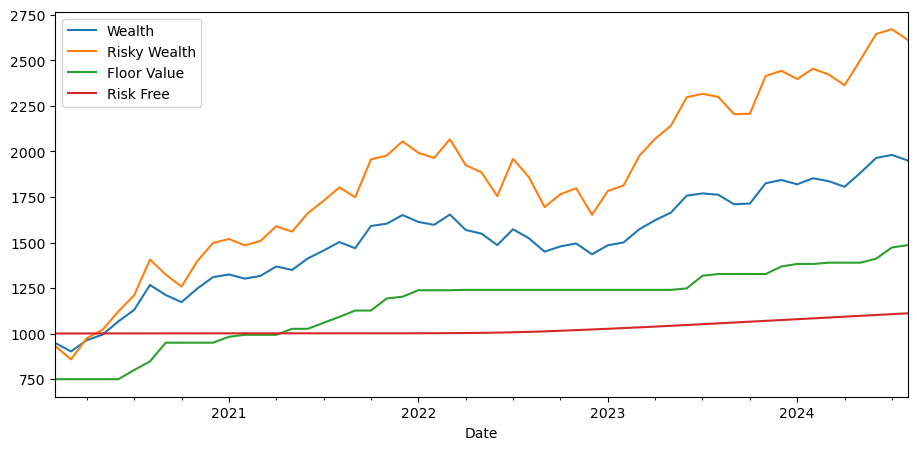

In [6]:
rf_monthly = ((1 + rf) ** (1/12)) - 1
rf_monthly = rf_monthly.reindex(mcap_returns.index).interpolate()
cppi(mcap_returns, rf_monthly, floor=0.75, m=3)[['Wealth', 'Risky Wealth', 'Floor Value']].plot(figsize=(11,5))
plt.plot((1 + rf_monthly).cumprod() * 1000, label='Risk Free')
plt.legend()
plt.show()

In the function below, we run a Monte Carlo simulation of the CPPI strategy, where we generate market returns using geometric Brownian motion and use those returns to run CPPI.

In [7]:
def cppi_gbm(init_inv=100, mu=0.07, sigma=0.15, freq=12, n_scenarios=100, rf=None, m=3, floor=0.9, col='Wealth'):
    years = rf.shape[0] / freq
    r = gbm(1, mu=mu, sigma=sigma, freq=freq, years=years, n_scenarios=n_scenarios)[: rf.shape[0]] - 1
    r.index = rf.index
    r.columns = pd.Series(r.columns).astype(str)
    
    return pd.DataFrame(np.array([cppi(r=r[x], rf=rf, m=m, init_inv=init_inv, floor=floor)[col].values for x in r.columns]).T, index=r.index)

Terminal wealth of the CPPI strategy with random market returns starting with $100 initial investment:

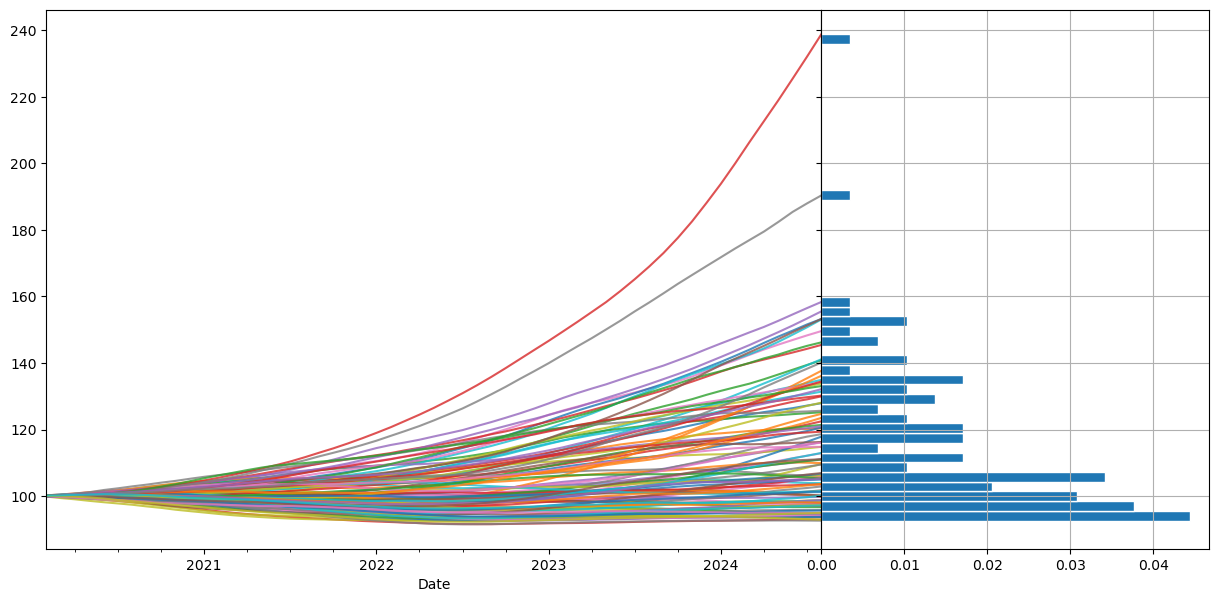

In [13]:
n_scenarios = 100
wealths = cppi_gbm(rf=rf_monthly, n_scenarios=n_scenarios, sigma=0.01, mu=0.0, m=3, floor=0.9)
fig, (wealth_ax, hist_ax) = plt.subplots(nrows=1, ncols=2, sharey=True, gridspec_kw={'width_ratios':[2, 1]}, figsize=(15, 7))
plt.subplots_adjust(wspace=0)
wealths.plot(ax=wealth_ax, legend=False, alpha=0.8)
wealths.iloc[-1].hist(ax=hist_ax, bins=50, ec='w', orientation='horizontal', density=True)
fig.show()

I have put together notebooks on portfolio optimization after learning these concepts on the Portfolio Construction and Analysis in Python course from the EDHEC Business School. To reference, some of the code might resemble the courseworks by Vijay Vaidyanathan, however, this is my take on the portfolio optimization concepts using live data from Yahoo Finance.